Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC3641 - Aprendizaje Automático Basado en Grafos <br>
Segundo Semestre 2025<br>


<h1><center> Tarea 3  </center></h1>
        Profesor: Marcelo Mendoza<br>
        Fecha de entrega: 22 de octubre


---

## Indicaciones

Se debe entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se asignará puntaje por el código implementado y los comentarios asociados a resultados.
- El notebook debe tener todas las celdas de código ejecutadas.
- Cualquier instancia de copia resultará en un 1.1 como nota de curso.

---

# Integrantes del grupo

* Estudiante 1: Juan Hernandez
* Estudiante 2: Ignacio Vergara
* Estudiante 3: Diego Larraguibel

# Librerías

In [1]:
import dgl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
import torch
import random
import torch.nn.functional as F
from functools import partial

seed = 1001
device = "cpu"

# Parte 1: Relational Graph Convolutional Network (R-GCN) (20 puntos)

En esta primera sección se trabaja con el dataset BGSDataset, disponible en dgl.

Ver enlace: https://www.dgl.ai/dgl_docs/generated/dgl.data.BGSDataset.html#dgl.data.BGSDataset

**Observación**

Para trabajar con el código visto en clases deben ajustar la versión de pytorch.

## 1.1 Conceptos básicos (5 puntos)


Responda las siguientes preguntas:

1. Mencione y describa los elementos que diferencian las arquitecturas **GCN** y **R-GCN**.

2. Explique las principales diferencias en el proceso de entrenamiento de arquitecturas basadas en **R-GCN**, considerando las tareas **Clasificación de nodos** y **Predicción de enlaces**

1. Las R-GCN generalizan las GCN, cuya arquitectura solo permite una relación por par de nodos, a múltiples relaciones. A nivel de implementación GCN aplica una convolución que combina las características de los vecinos de cada nodo mediante una matriz de adyacencia. En cambio, la R-GCN, al trabajar en grafos multirrelacionales considera un conjunto de matrices de peso específicas por tipo de relación y combina sus efectos mediante una suma ponderada.

2. En el proceso de entrenamiento, las R-GCN pueden aplicarse a distintas tareas, principalmente clasificación de nodos y predicción de enlaces, y cada una requiere un enfoque diferente. En la clasificación de nodos, el modelo aprende a predecir la etiqueta o categoría de un tipo específico de nodo, usando como entrada la información de sus vecinos y de las relaciones que lo conectan con ellos. Este entrenamiento se realiza con una función de pérdida de entropía cruzada y un conjunto de nodos etiquetados, de manera similar a una GCN tradicional. En cambio, en la predicción de enlaces, el modelo busca estimar si debería existir una conexión entre dos nodos del grafo. Para ello, primero genera representaciones (embeddings) de los nodos y luego utiliza un decodificador que combina los embeddings de los pares de nodos candidatos.

**Fuente:**  
Clases, [Tutorial de DGL](https://www.dgl.ai/dgl_docs/en/2.3.x/tutorials/models/1_gnn/4_rgcn.html)


## 1.2 Análisis descriptivo (5 puntos)

Grafique el grafo y calcule medidas descriptivas para caracterizarlo. Comente sus resultados.

**Observación**

En caso de no poder graficar la red completa, se recomienda trabajar con un subconjunto de 15.000 nodos (demora cerca de 12 minutos). Esto **SOLO** aplica para este punto. **La actividad 1.3 debe considerar todo el grafo.**

Respuesta:

In [2]:
ds = dgl.data.BGSDataset()
g_hetero = ds[0]
category = ds.predict_category
category_id = g_hetero.get_ntype_id(category)
num_rels = len(g_hetero.etypes)
num_classes = ds.num_classes

train_mask = g_hetero.nodes[category].data['train_mask']
test_mask = g_hetero.nodes[category].data['test_mask']
label = g_hetero.nodes[category].data['label']

Done loading data from cached files.


In [ ]:
G = dgl.to_networkx(g_hetero)
G_undirected = G.to_undirected()

In [23]:
G.number_of_nodes()

94806

In [21]:
sample = random.sample(list(G.nodes()), k=min(15000, G.number_of_nodes()))
H = G_undirected.subgraph(sample)
pos_C = nx.spring_layout(H, seed=seed, iterations=50, weight=None, threshold=1e-4)

Text(0.5, 1.0, 'Grafo de BGS (subgrafo de 5000 nodos)')

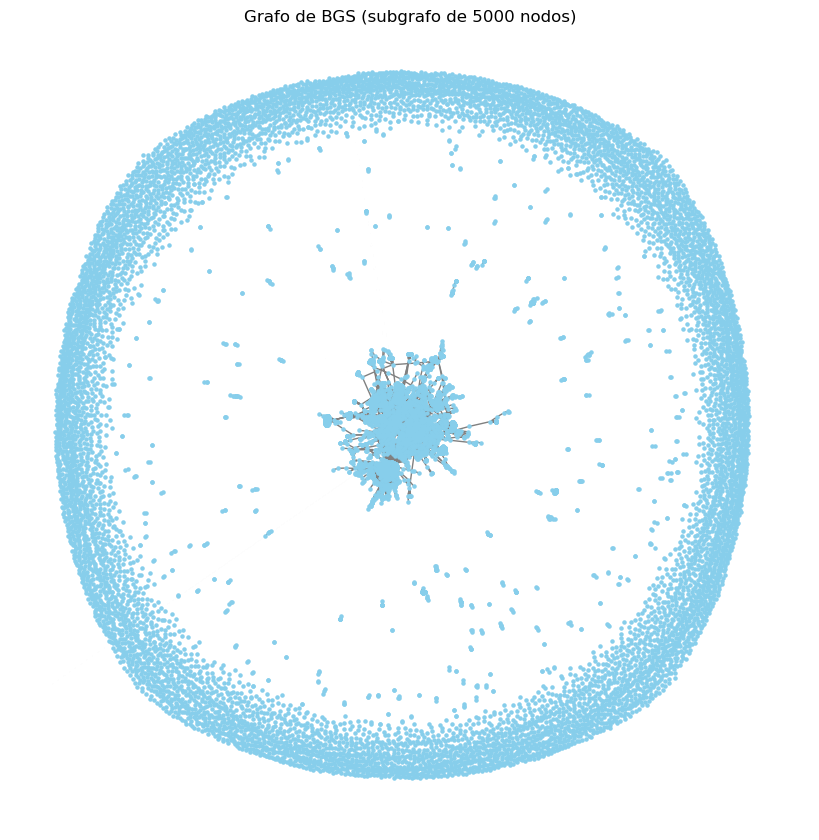

In [22]:
plt.figure(figsize=(8, 8))
nx.draw(H, pos_C, node_size=5, node_color='skyblue', edge_color='gray', with_labels=False,)
plt.title('Grafo de BGS (subgrafo de 15.000 nodos)')

In [26]:
def funcion_descriptora(G, nombre):
    # Printeo de las características solicitadas
    df_datos = pd.DataFrame([{"Nodos": None, "Aristas": None, "Componentes": None, "Grado Promedio": None, "Diámetro": None, "Camino mínimo promedio": None}])
    df_datos["Nodos"] = len(G.nodes())
    df_datos["Aristas"] = len(G.edges())
    df_datos["Componentes"] = nx.number_connected_components(G)
    degrees = np.array([G.degree(n) for n in G.nodes()])
    df_datos["Grado Promedio"] = np.mean(degrees)
    # En caso de que el grafo no sea conexo se debe determinar el diámetro analizando cada subgrafo del mismo
    if nx.is_connected(G):
        df_datos["Diámetro"] = nx.diameter(G)
    else:
        diam = 0
        for component in nx.connected_components(G):
            subgraph = G.subgraph(component)
            d = nx.diameter(subgraph)
            if diam <= d:
                diam = d
        df_datos["Diámetro"] = diam

    componentes = list(nx.connected_components(G))
    nodos_mayor_comp = max(componentes, key=len)
    mayor_comp = G.subgraph(nodos_mayor_comp)
    cmp_mayor_comp = nx.average_shortest_path_length(mayor_comp) # Camino mínimo promedio de la mayor componente
    df_datos["Camino mínimo promedio"] = cmp_mayor_comp

    print(f"Las estadísticas del grafo {nombre} son:")
    display(df_datos)

funcion_descriptora(H, "BGS")

Las estadísticas del grafo BGS son:


,Nodos,Aristas,Componentes,Grado Promedio,Diámetro,Camino mínimo promedio
0,15000,9097,8865,1.212933,21,6.225154


Se analizan los resultados para el subconjunto aleatorio de 15000 nodos delgrafo. Tanto del gráfico como de la tabla descriptiva podemos ver que hay un gran número de componentes (8865). Así mismo, el grafo presenta cadenas largas de nodos, con un diámetro de 21 y camino mínimo promedio 6.22.

## 1.3 Implementación R-GCN (10 puntos)

Entrene una arquitectura R-GCN para clasificar entidades. Defina el número de épocas de manera que se garantice la convergencia del entrenamiento y justifique su elección de hiperpámetros.

Grafique la función de pérdida y accuracy. Comente sus resultados.

Respuesta:

In [81]:
# Copiamos las clases para construir R-GCN desde la clase 10.

from functools import partial

import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph


class RGCNLayer(nn.Module):
    def __init__(
        self,
        in_feat,
        out_feat,
        num_rels,
        num_bases=-1, # esto indica que num_bases = num_rels
        bias=None,
        activation=None,
        is_input_layer=False,
    ):
        super(RGCNLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.num_rels = num_rels
        self.num_bases = num_bases # implementación eficiente de relaciones con combinación lineal de matrices base.
        self.bias = bias
        self.activation = activation
        self.is_input_layer = is_input_layer

        
        if self.num_bases <= 0 or self.num_bases > self.num_rels:
            self.num_bases = self.num_rels
        
        self.weight = nn.Parameter(
            torch.Tensor(self.num_bases, self.in_feat, self.out_feat)
        )
        if self.num_bases < self.num_rels:
            
            self.w_comp = nn.Parameter(
                torch.Tensor(self.num_rels, self.num_bases)
            )
        # add bias
        if self.bias:
            self.bias = nn.Parameter(torch.Tensor(out_feat))
        # init trainable parameters
        nn.init.xavier_uniform_(
            self.weight, gain=nn.init.calculate_gain("relu")
        )
        if self.num_bases < self.num_rels:
            nn.init.xavier_uniform_(
                self.w_comp, gain=nn.init.calculate_gain("relu")
            )
        if self.bias:
            nn.init.xavier_uniform_(
                self.bias, gain=nn.init.calculate_gain("relu")
            )

    def forward(self, g):
        if self.num_bases < self.num_rels:
            weight = self.weight.view(
                self.in_feat, self.num_bases, self.out_feat
            )
            weight = torch.matmul(self.w_comp, weight).view(
                self.num_rels, self.in_feat, self.out_feat
            )
        else:
            weight = self.weight
        if self.is_input_layer:

            def message_func(edges):
                embed = weight.view(-1, self.out_feat)
                index = edges.data[dgl.ETYPE] * self.in_feat + edges.src["id"]
                return {"msg": embed[index] * edges.data["norm"]}

        else:

            def message_func(edges):
                w = weight[edges.data[dgl.ETYPE]]
                msg = torch.bmm(edges.src["h"].unsqueeze(1), w).squeeze()
                msg = msg * edges.data["norm"]
                return {"msg": msg}

        def apply_func(nodes):
            h = nodes.data["h"]
            if self.bias:
                h = h + self.bias
            if self.activation:
                h = self.activation(h)
            return {"h": h}

        g.update_all(message_func, fn.sum(msg="msg", out="h"), apply_func)
        

class Model(nn.Module):
    def __init__(
        self,
        num_nodes,
        h_dim,
        out_dim,
        num_rels,
        num_bases=-1,
        num_hidden_layers=1,
    ):
        super(Model, self).__init__()
        self.num_nodes = num_nodes
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.num_rels = num_rels
        self.num_bases = num_bases
        self.num_hidden_layers = num_hidden_layers

        # create rgcn layers
        self.build_model()

        # create initial features
        self.features = self.create_features()

    def build_model(self):
        self.layers = nn.ModuleList()
        # input to hidden
        i2h = self.build_input_layer()
        self.layers.append(i2h)
        # hidden to hidden
        for _ in range(self.num_hidden_layers):
            h2h = self.build_hidden_layer()
            self.layers.append(h2h)
        # hidden to output
        h2o = self.build_output_layer()
        self.layers.append(h2o)

    # initialize feature for each node
    def create_features(self):
        features = torch.arange(self.num_nodes)
        return features

    def build_input_layer(self):
        return RGCNLayer(
            self.num_nodes,
            self.h_dim,
            self.num_rels,
            self.num_bases,
            activation=F.relu,
            is_input_layer=True,
        )

    def build_hidden_layer(self):
        return RGCNLayer(
            self.h_dim,
            self.h_dim,
            self.num_rels,
            self.num_bases,
            activation=F.relu,
        )

    def build_output_layer(self):
        return RGCNLayer(
            self.h_dim,
            self.out_dim,
            self.num_rels,
            self.num_bases,
            activation=None,   # <-- antes: partial(F.softmax, dim=1)
        )


    def forward(self, g):
        if self.features is not None:
            g.ndata["id"] = self.features
        for layer in self.layers:
            layer(g)
        return g.ndata.pop("h")

In [94]:
g = dgl.to_homogeneous(g_hetero)
# justo después de crear el grafo homogéneo
E = g.num_edges()
dev = g.ndata[dgl.NTYPE].device
if 'norm' not in g.edata:
    g.edata['norm'] = torch.ones((E, 1), dtype=torch.float32, device=dev)
    
print(g)

Graph(num_nodes=94806, num_edges=672884,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64), 'norm': Scheme(shape=(1,), dtype=torch.float32)})


In [95]:
# 1) Asegura 'norm' en edges
if 'norm' not in g.edata:
    g.edata['norm'] = torch.ones(g.num_edges(), dtype=torch.float32, device=g.device if hasattr(g, "device") else None)

target_mask_global = (g.ndata[dgl.NTYPE] == category_id)
target_idx = torch.nonzero(target_mask_global, as_tuple=False).squeeze()
nid_target = g.ndata[dgl.NID][target_mask_global]

# 3) Reconstruye labels y máscaras en el homogéneo
labels_full = torch.full((g.num_nodes(),), -1, dtype=torch.long, device=nid_target.device)
labels_full[target_mask_global] = label[nid_target].long()

train_mask_full = torch.zeros(g.num_nodes(), dtype=torch.bool, device=nid_target.device)
train_mask_full[target_mask_global] = train_mask[nid_target].bool()

test_mask_full = torch.zeros(g.num_nodes(), dtype=torch.bool, device=nid_target.device)
test_mask_full[target_mask_global]  = test_mask[nid_target].bool()

train_idx = torch.nonzero(train_mask_full[target_idx], as_tuple=False).flatten()
test_idx  = torch.nonzero(test_mask_full[target_idx],  as_tuple=False).flatten()
labels_t  = labels_full[target_idx]

In [96]:
# configurations
n_hidden = 16  # number of hidden units
n_bases = -1  # use number of relations as number of bases
n_hidden_layers = 1  # use 1 input layer, 1 output layer, no hidden layer
n_epochs = 100  # epochs to train
lr = 0.01  # learning rate
l2norm = 0  # L2 norm coefficient

node_ids = torch.arange(g.num_nodes())
target_idx = node_ids[g.ndata[dgl.NTYPE] == category_id]

In [97]:
# Funcion para facilitar el entrenamiento y la validación

def train_model(
    n_epochs=50, lr=0.01, l2norm=0.0,
    patience=10, min_delta=1e-3, verbose=False, model=None
):
    if model is None:
        raise ValueError("Se debe proveer un modelo")

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2norm)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    best_val_loss = float('inf')
    best_epoch = -1
    best_state = None
    no_improve = 0

    for epoch in range(n_epochs):
        # ---------- TRAIN ----------
        model.train()
        opt.zero_grad()
        logits_all = model(g)                  # forward
        logits_trg = logits_all[target_idx]
        loss = F.cross_entropy(logits_trg[train_idx], labels_t[train_idx])
        loss.backward()
        opt.step()

        # ---------- EVAL ----------
        model.eval()
        with torch.no_grad():
            logits_all = model(g)
            logits_trg = logits_all[target_idx]

            # train metrics
            pred_tr = logits_trg[train_idx].argmax(1)
            y_tr = labels_t[train_idx]
            train_acc = (pred_tr == y_tr).float().mean().item()
            train_loss = F.cross_entropy(logits_trg[train_idx], y_tr).item()
            pred_va = logits_trg[test_idx].argmax(1)
            y_va = labels_t[test_idx]
            val_loss = F.cross_entropy(logits_trg[test_idx], y_va).item()
            val_acc  = (pred_va == y_va).float().mean().item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if verbose:
            print(f"Epoch {epoch:05d} | Train Acc: {train_acc:.4f} | "
                  f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}")

        # ---------- EARLY STOP ----------
        improved = (best_val_loss - val_loss) > min_delta
        if improved or (best_epoch < 0 and val_loss < best_val_loss):
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                if verbose:
                    print(f"Early stopping en epoch {epoch} (mejor epoch: {best_epoch})")
                break

    history = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs,
    }
    best = {
        "epoch": best_epoch,
        "val_loss": best_val_loss,
        "val_acc": val_accs[best_epoch] if best_epoch >= 0 else None,
        "state_dict": best_state,
    }
    return history, best

In [98]:
# Testing with different hyperparams
from itertools import product

hidden_layers_options = [0, 1, 2]
hidden_dim_options = [8, 16, 32]
param_grid = [
    {"n_hidden_layers": nl, "n_hidden": nh}
    for nl, nh in product(hidden_layers_options, hidden_dim_options)
]

In [102]:
best_of_bests = None
best_val_acc = 0.0

for params in param_grid:
    print(f"Probando config: {params}")
    model = Model(
        g.num_nodes(),
        params["n_hidden"],
        num_classes,
        num_rels,
        num_bases=n_bases,
        num_hidden_layers=params["n_hidden_layers"],
    )

    history, best = train_model(model=model, n_epochs=n_epochs, patience=30)
    print(f"Best val_acc: {best['val_acc']:.4f} (epoch {best['epoch']})\n")
    if best["val_acc"] > best_val_acc:
        best_of_bests = {
            "model": model,
            "params": params,
            "history": history,
            "best": best,
        }
        best_val_acc = best["val_acc"]

Probando config: {'n_hidden_layers': 0, 'n_hidden': 8}
Best val_acc: 0.8621 (epoch 98)

Probando config: {'n_hidden_layers': 0, 'n_hidden': 16}
Best val_acc: 0.8276 (epoch 16)

Probando config: {'n_hidden_layers': 0, 'n_hidden': 32}
Best val_acc: 0.8276 (epoch 14)

Probando config: {'n_hidden_layers': 1, 'n_hidden': 8}
Best val_acc: 0.7241 (epoch 9)

Probando config: {'n_hidden_layers': 1, 'n_hidden': 16}
Best val_acc: 0.4483 (epoch 4)

Probando config: {'n_hidden_layers': 1, 'n_hidden': 32}
Best val_acc: 0.6552 (epoch 4)

Probando config: {'n_hidden_layers': 2, 'n_hidden': 8}
Best val_acc: 0.6897 (epoch 21)

Probando config: {'n_hidden_layers': 2, 'n_hidden': 16}
Best val_acc: 0.6207 (epoch 17)

Probando config: {'n_hidden_layers': 2, 'n_hidden': 32}
Best val_acc: 0.9310 (epoch 30)



En la parte de arriba se puede observar la validación de hiperparámetros realizada. Por un tema de cómputo, solo testeamos los hiperparámetros de ```cantidad de capas ocultas``` y ```cantidad de neuronas por capa oculta```. Se observa que varios modelos tienen la misma accuracy para el test de validación, y se elige entre ellos aquel que tiene la menor cantidad de parámetros. Finalmente, el campeón es ```{'n_hidden_layers': 2, 'n_hidden': 32}```, el cual obtuvo una accuracy de 0.93.

En cuanto al resto de los hiperparámetros, se mantuvieron constantes durante toda la búsqueda. Se utilizó una tasa de aprendizaje de 0.01, un número máximo de épocas (n_epochs) igual a 100. Además, se implementó un criterio de early stopping con una paciencia de 30 épocas y una mejora mínima de 1e-3, de modo que el entrenamiento se detuviera automáticamente si no se observaban mejoras relevantes en la pérdida de validación.


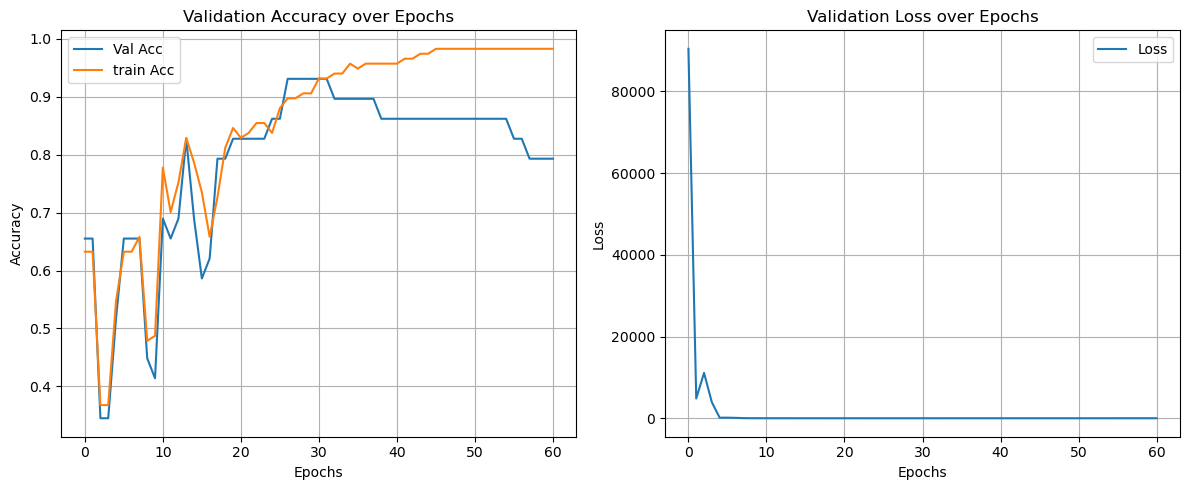

In [109]:
# Plots with a subplot the accs and loss

best_hist = best_of_bests["history"]
val_acc = best_hist["val_acc"]
train_acc = best_hist["train_acc"]
val_loss = best_hist["val_loss"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(val_acc, label='Val Acc')
ax1.plot(train_acc, label='train Acc')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Validation Accuracy over Epochs')
ax1.legend()
ax1.grid(True)

ax2.plot(val_loss, label='Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss over Epochs')
ax2.legend()
ax2.grid(True)
plt.tight_layout()

Cabe mencionar que la mejor época, y por lo tanto aquella desde la cual se conserva el modelo final, corresponde a la época 30. No obstante, dado que el criterio de early stopping consideró una paciencia de 30 épocas, se muestran las 60 épocas completas del entrenamiento. El proceso evidencia una marcada inestabilidad inicial en la precisión (accuracy), con fuertes oscilaciones durante las primeras 20 épocas, tras las cuales el modelo comienza a estabilizarse. Aun así, se observa que la precisión de entrenamiento aumenta de forma sostenida después de la época 30, mientras que la precisión de validación empieza a disminuir, lo que sugiere la aparición de overfitting.

**Observación**

Para la pregunta 2 se recomienda revisar la publicación **Modeling
relational data with graph convolutional networks** (Schlichtkrull et al., 2018). Disponible en: https://arxiv.org/abs/1703.06103

# Parte 2: Graph Transformer (20 puntos)

En esta segunda sección se debe trabajar con el conjunto de datos **caco2_wang**, contenido en el benchmark de ADMET.

**Observación**

Para cargar el dataset debe seguir el procedimiento visto en clases (8 - Graph-transformer)

## 2.1 Conceptos básicos (5 puntos)

Responda las siguientes preguntas:

1. En el contexto de Graph Transformers, defina el concepto de **sparseness**. ¿Qué implicancias tiene este concepto en las capacidades de cómputo requeridas para trabajar con dichas arquitecturas?

2. Explique el concepto de **positional encoding** en el contexto de los Graph Transformers y compare su formulación con la empleada en el Transformer original (Vaswani et al., 2017).

**Observación**

Se recomienda revisar la publicación **Attention Is All You Need** (Vaswani et al., 2017). Disponible en: https://papers.neurips.cc/paper/7181-attention-is-all-you-need.pdf

Respuesta:

Respuesta:

1.- Sparseness hace alusión a la cantidad de conexiones a las cuales se les aplica el mecanismo de atención (vecindario de cada nodo) vs las conexiones a las que se les podría aplicar. Al aplicar el mecanismo de atención de esta manera semreduce significativamente la complejidad inherente de esta arquitectura pues con ello el mecanismo solo debe ser aplicado a un subconjunto de los nodos, por lo que la capacidad de computo requerida para trabajar con estas arquitecturas es mucho menor del que sería sin hacer uso de esta estrcutuctura sparse inherente al grafo.

2.- El positional encoding en un grafo corresponde a un embedding que captura la posición de un nodo en el grafo en términos globales, es decir su uso está relacionado a aprender la estructura general del grafo por lo que se busca aprender una estructura que es relativa a cada nodo en ese sentido. Logra capturar toda esta información mediante el uso de los vectores propios del laplaciano del grafo. Por otro lado, los positional encodings en el transformer original buscan poder capturar el orden de la secuencia de texto dada, siguiendo así un orden de posición absoluto, por otro lado estos encodings se obtienen mediante funciones sinusoidales (diferencia obviamente al caso del graph transformer).

Fuentes: [Fuente Sparseness](https://kumo.ai/research/introduction-to-graph-transformers/), [Fuente Positional Encoding](https://www.capitalone.com/tech/ai/positional-encoding-in-graph-transformers/)

## 2.2 Implementación Graph Transformer (15 puntos)

Proponga cuatro modelos para la tarea de regresión asociada al dataset **caco2_wang**, utilizando la arquitectura **Graph Transformer**. Para ello, haga modificaciones tanto en el número de cabezales como en el número de capas. Justifique sus decisiones.

Compare sus resultados con el Leaderboard disponible en: https://tdcommons.ai/benchmark/admet_group/01caco2/

**Observación**

* Defina el número de épocas de manera que se garantice la convergencia del entrenamiento.
* Trabaje con los conjuntos ya definidos de train, val y test.

Respuesta:

In [ ]:
import logging
import importlib


import numpy as np
import rdkit
from rdkit import RDLogger
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
import torchmetrics
from torchmetrics import MeanAbsoluteError
from tdc import utils
from gt_pyg.data.utils import (
    get_tensor_data,
    get_node_dim,
    get_edge_dim,
    get_train_valid_test_data,
)
from gt_pyg.nn.model import GraphTransformerNet
from torchmetrics import MeanAbsoluteError
from torch_geometric import *

import torch._dynamo

In [ ]:
# Obteniendo el conjunto de datos de manera similar a como se hizo en clases
PE_DIM = 6
(tr, va, te) = get_train_valid_test_data('caco2_wang', min_num_atoms=0)
tr_dataset = get_tensor_data(tr.Drug.to_list(), tr.Y.to_list(), pe_dim=PE_DIM)
va_dataset = get_tensor_data(va.Drug.to_list(), va.Y.to_list(), pe_dim=PE_DIM)
te_dataset = get_tensor_data(te.Drug.to_list(), te.Y.to_list(), pe_dim=PE_DIM)
NODE_DIM = get_node_dim()
EDGE_DIM = get_edge_dim()

print(f'Number of training examples: {len(tr_dataset)}')
print(f'Number of validation examples: {len(va_dataset)}')
print(f'Number of test examples: {len(te_dataset)}')

train_loader = DataLoader(tr_dataset, batch_size=64)
val_loader = DataLoader(va_dataset, batch_size=512)
test_loader = DataLoader(te_dataset, batch_size=512)

Found local copy...
Loading...
Done!


Processing data: 0it [00:00, ?it/s]

Processing data: 0it [00:00, ?it/s]

Processing data: 0it [00:00, ?it/s]

Processing data: 0it [00:00, ?it/s]

Processing data: 0it [00:00, ?it/s]

Number of training examples: 637
Number of validation examples: 91
Number of test examples: 182


In [ ]:
print(f'Node dim: {NODE_DIM}')
print(f'Edge dim: {EDGE_DIM}')

Node dim: 76
Edge dim: 10


In [ ]:
def train(epoch, loss_func):
    model_1.train()
    train_mae = MeanAbsoluteError().to(device)

    for data in train_loader:
        data = data.to(device)
        optimizer_1.zero_grad()

        # randomly flip sign of eigenvectors

        #device = data.pe.device  # Get the device of data.pe
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0)
        #batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
        (out,_) = model_1(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch, zero_var=False)
        loss = loss_func(out.squeeze(), data.y)
        loss.backward()
        optimizer_1.step()

        train_mae.update(out.squeeze(), data.y)

    return train_mae.compute()


@torch.no_grad()
def test(loader):
    model_1.eval()
    test_mae = MeanAbsoluteError().to(device)

    total_error = 0
    for data in loader:
        data = data.to(device)
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0)
        (out,_) = model_1(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)

        test_mae.update(out.squeeze(), data.y)

    return test_mae.compute()

train_loss = nn.L1Loss(reduction='mean')
torch._dynamo.config.suppress_errors = True

device = torch.device('cuda')

model_1 = GraphTransformerNet(node_dim_in=NODE_DIM,
                            edge_dim_in=EDGE_DIM,
                            pe_in_dim=PE_DIM,
                            num_gt_layers=2,
                            hidden_dim=256,
                            num_heads=8,
                            norm='ln',
                            gate=True,
                            qkv_bias=True,
                            gt_aggregators=['sum'],
                            aggregators=['sum'],
                            dropout=0.15,
                            act='gelu').to(device)

if int(torch.__version__.split('.')[0]) >= 2:
    model_1 = torch_geometric.compile(model_1)

optimizer_1 = torch.optim.AdamW(model_1.parameters(), lr=2e-4)
scheduler_1 = ReduceLROnPlateau(optimizer_1, mode='min', factor=0.5, patience=10,
                              min_lr=0.00001)
best_epoch = 0
best_validation_loss = np.inf
test_set_mae = np.inf
for epoch in range(1, 151):
    tr_loss = train(epoch, loss_func=train_loss)
    va_loss = test(val_loader)
    te_loss = test(test_loader)
    scheduler_1.step(va_loss)
    print(f'Epoch: {epoch:02d}, Loss entrenamiento: {tr_loss:.4f}, Loss validation: {va_loss:.4f}, '
          f'Loss Test: {te_loss:.4f}')
    if va_loss < best_validation_loss:
        best_epoch = epoch
        best_validation_loss = va_loss
        test_set_mae = te_loss

print("\nModel's performance on the test set\n"
        "===================================\n"
        f'MAE={test_set_mae}\n'
        f'Epoch={best_epoch}')

Epoch: 01, Loss entrenamiento: 2.3555, Loss validation: 5.0838, Loss Test: 5.5605
Epoch: 02, Loss entrenamiento: 1.9100, Loss validation: 2.1950, Loss Test: 2.3186
Epoch: 03, Loss entrenamiento: 1.8036, Loss validation: 1.6869, Loss Test: 1.4937
Epoch: 04, Loss entrenamiento: 1.7300, Loss validation: 2.3269, Loss Test: 2.3809
Epoch: 05, Loss entrenamiento: 1.7310, Loss validation: 2.7081, Loss Test: 2.8063
Epoch: 06, Loss entrenamiento: 1.4459, Loss validation: 1.9447, Loss Test: 1.9522
Epoch: 07, Loss entrenamiento: 1.3881, Loss validation: 1.7597, Loss Test: 1.7938
Epoch: 08, Loss entrenamiento: 1.4060, Loss validation: 1.8553, Loss Test: 1.8900
Epoch: 09, Loss entrenamiento: 1.4343, Loss validation: 2.2152, Loss Test: 2.3670
Epoch: 10, Loss entrenamiento: 1.4447, Loss validation: 2.1980, Loss Test: 2.2295
Epoch: 11, Loss entrenamiento: 1.5057, Loss validation: 2.7948, Loss Test: 2.9220
Epoch: 12, Loss entrenamiento: 1.1777, Loss validation: 1.4246, Loss Test: 1.4968
Epoch: 13, Loss 

In [ ]:
def train(epoch, loss_func):
    model_2.train()
    train_mae = MeanAbsoluteError().to(device)

    for data in train_loader:
        data = data.to(device)
        optimizer_2.zero_grad()

        # randomly flip sign of eigenvectors

        #device = data.pe.device  # Get the device of data.pe
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0)
        #batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
        (out,_) = model_2(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch, zero_var=False)
        loss = loss_func(out.squeeze(), data.y)
        loss.backward()
        optimizer_2.step()

        train_mae.update(out.squeeze(), data.y)

    return train_mae.compute()


@torch.no_grad()
def test(loader):
    model_2.eval()
    test_mae = MeanAbsoluteError().to(device)

    total_error = 0
    for data in loader:
        data = data.to(device)
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0)
        (out,_) = model_2(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)

        test_mae.update(out.squeeze(), data.y)

    return test_mae.compute()

train_loss = nn.L1Loss(reduction='mean')
torch._dynamo.config.suppress_errors = True

device = torch.device('cuda')

model_2 = GraphTransformerNet(node_dim_in=NODE_DIM,
                            edge_dim_in=EDGE_DIM,
                            pe_in_dim=PE_DIM,
                            num_gt_layers=2,
                            hidden_dim=256,
                            num_heads=4,
                            norm='ln',
                            gate=True,
                            qkv_bias=True,
                            gt_aggregators=['sum'],
                            aggregators=['sum'],
                            dropout=0.15,
                            act='gelu').to(device)

if int(torch.__version__.split('.')[0]) >= 2:
    model_2 = torch_geometric.compile(model_2)

optimizer_2 = torch.optim.AdamW(model_2.parameters(), lr=2e-4)
scheduler_2 = ReduceLROnPlateau(optimizer_2, mode='min', factor=0.5, patience=10,
                              min_lr=0.00001)
best_epoch = 0
best_validation_loss = np.inf
test_set_mae = np.inf
for epoch in range(1, 151):
    tr_loss = train(epoch, loss_func=train_loss)
    va_loss = test(val_loader)
    te_loss = test(test_loader)
    scheduler_2.step(va_loss)
    print(f'Epoch: {epoch:02d}, Loss entrenamiento: {tr_loss:.4f}, Loss validation: {va_loss:.4f}, '
          f'Loss Test: {te_loss:.4f}')
    if va_loss < best_validation_loss:
        best_epoch = epoch
        best_validation_loss = va_loss
        test_set_mae = te_loss

print("\nModel's performance on the test set\n"
        "===================================\n"
        f'MAE={test_set_mae}\n'
        f'Epoch={best_epoch}')

Epoch: 01, Loss entrenamiento: 3.6599, Loss validation: 2.6285, Loss Test: 2.5885
Epoch: 02, Loss entrenamiento: 2.1688, Loss validation: 2.9574, Loss Test: 3.0987
Epoch: 03, Loss entrenamiento: 1.8248, Loss validation: 1.6429, Loss Test: 1.8182
Epoch: 04, Loss entrenamiento: 1.7584, Loss validation: 1.4065, Loss Test: 1.4449
Epoch: 05, Loss entrenamiento: 1.7371, Loss validation: 1.7603, Loss Test: 1.7804
Epoch: 06, Loss entrenamiento: 1.4816, Loss validation: 1.5238, Loss Test: 1.6433
Epoch: 07, Loss entrenamiento: 1.2927, Loss validation: 1.2323, Loss Test: 1.2671
Epoch: 08, Loss entrenamiento: 1.2425, Loss validation: 1.2729, Loss Test: 1.3259
Epoch: 09, Loss entrenamiento: 1.3767, Loss validation: 1.8031, Loss Test: 1.8085
Epoch: 10, Loss entrenamiento: 1.4689, Loss validation: 2.0005, Loss Test: 2.0377
Epoch: 11, Loss entrenamiento: 1.3039, Loss validation: 1.7162, Loss Test: 1.7754
Epoch: 12, Loss entrenamiento: 1.3518, Loss validation: 1.2298, Loss Test: 1.2446
Epoch: 13, Loss 

In [ ]:
def train(epoch, loss_func):
    model_3.train()
    train_mae = MeanAbsoluteError().to(device)

    for data in train_loader:
        data = data.to(device)
        optimizer_3.zero_grad()

        # randomly flip sign of eigenvectors

        #device = data.pe.device  # Get the device of data.pe
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0)
        #batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
        (out,_) = model_3(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch, zero_var=False)
        loss = loss_func(out.squeeze(), data.y)
        loss.backward()
        optimizer_3.step()

        train_mae.update(out.squeeze(), data.y)

    return train_mae.compute()


@torch.no_grad()
def test(loader):
    model_3.eval()
    test_mae = MeanAbsoluteError().to(device)

    total_error = 0
    for data in loader:
        data = data.to(device)
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0)
        (out,_) = model_3(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)

        test_mae.update(out.squeeze(), data.y)

    return test_mae.compute()

train_loss = nn.L1Loss(reduction='mean')
torch._dynamo.config.suppress_errors = True

device = torch.device('cuda')

model_3 = GraphTransformerNet(node_dim_in=NODE_DIM,
                            edge_dim_in=EDGE_DIM,
                            pe_in_dim=PE_DIM,
                            num_gt_layers=4,
                            hidden_dim=256,
                            num_heads=2,
                            norm='ln',
                            gate=True,
                            qkv_bias=True,
                            gt_aggregators=['sum'],
                            aggregators=['sum'],
                            dropout=0.15,
                            act='gelu').to(device)

if int(torch.__version__.split('.')[0]) >= 2:
    model_3 = torch_geometric.compile(model_3)

optimizer_3 = torch.optim.AdamW(model_3.parameters(), lr=2e-4)
scheduler_3 = ReduceLROnPlateau(optimizer_3, mode='min', factor=0.5, patience=10,
                              min_lr=0.00001)
best_epoch = 0
best_validation_loss = np.inf
test_set_mae = np.inf
for epoch in range(1, 151):
    tr_loss = train(epoch, loss_func=train_loss)
    va_loss = test(val_loader)
    te_loss = test(test_loader)
    scheduler_3.step(va_loss)
    print(f'Epoch: {epoch:02d}, Loss entrenamiento: {tr_loss:.4f}, Loss validation: {va_loss:.4f}, '
          f'Loss Test: {te_loss:.4f}')
    if va_loss < best_validation_loss:
        best_epoch = epoch
        best_validation_loss = va_loss
        test_set_mae = te_loss

print("\nModel's performance on the test set\n"
        "===================================\n"
        f'MAE={test_set_mae}\n'
        f'Epoch={best_epoch}')

Epoch: 01, Loss entrenamiento: 2.8047, Loss validation: 4.7880, Loss Test: 4.5637
Epoch: 02, Loss entrenamiento: 1.7896, Loss validation: 2.5353, Loss Test: 2.5318
Epoch: 03, Loss entrenamiento: 1.8390, Loss validation: 1.4342, Loss Test: 1.5237
Epoch: 04, Loss entrenamiento: 1.7429, Loss validation: 2.1181, Loss Test: 2.0927
Epoch: 05, Loss entrenamiento: 1.3857, Loss validation: 1.2433, Loss Test: 1.1481
Epoch: 06, Loss entrenamiento: 1.2020, Loss validation: 0.9627, Loss Test: 0.9706
Epoch: 07, Loss entrenamiento: 1.1666, Loss validation: 1.2101, Loss Test: 1.2745
Epoch: 08, Loss entrenamiento: 1.3805, Loss validation: 1.9096, Loss Test: 1.9438
Epoch: 09, Loss entrenamiento: 1.5966, Loss validation: 2.4628, Loss Test: 2.3859
Epoch: 10, Loss entrenamiento: 1.5137, Loss validation: 1.0215, Loss Test: 1.0963
Epoch: 11, Loss entrenamiento: 1.3092, Loss validation: 1.2201, Loss Test: 1.0497
Epoch: 12, Loss entrenamiento: 1.1116, Loss validation: 1.4209, Loss Test: 1.3616
Epoch: 13, Loss 

In [ ]:
def train(epoch, loss_func):
    model_4.train()
    train_mae = MeanAbsoluteError().to(device)

    for data in train_loader:
        data = data.to(device)
        optimizer_4.zero_grad()

        # randomly flip sign of eigenvectors

        #device = data.pe.device  # Get the device of data.pe
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0)
        #batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
        (out,_) = model_4(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch, zero_var=False)
        loss = loss_func(out.squeeze(), data.y)
        loss.backward()
        optimizer_4.step()

        train_mae.update(out.squeeze(), data.y)

    return train_mae.compute()


@torch.no_grad()
def test(loader):
    model_4.eval()
    test_mae = MeanAbsoluteError().to(device)

    total_error = 0
    for data in loader:
        data = data.to(device)
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0)
        (out,_) = model_4(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)

        test_mae.update(out.squeeze(), data.y)

    return test_mae.compute()

train_loss = nn.L1Loss(reduction='mean')
torch._dynamo.config.suppress_errors = True

device = torch.device('cuda')

model_4 = GraphTransformerNet(node_dim_in=NODE_DIM,
                            edge_dim_in=EDGE_DIM,
                            pe_in_dim=PE_DIM,
                            num_gt_layers=4,
                            hidden_dim=256,
                            num_heads=4,
                            norm='ln',
                            gate=True,
                            qkv_bias=True,
                            gt_aggregators=['sum'],
                            aggregators=['sum'],
                            dropout=0.15,
                            act='gelu').to(device)

if int(torch.__version__.split('.')[0]) >= 2:
    model_4 = torch_geometric.compile(model_4)

optimizer_4 = torch.optim.AdamW(model_4.parameters(), lr=2e-4)
scheduler_4 = ReduceLROnPlateau(optimizer_4, mode='min', factor=0.5, patience=10,
                              min_lr=0.00001)
best_epoch = 0
best_validation_loss = np.inf
test_set_mae = np.inf
for epoch in range(1, 151):
    tr_loss = train(epoch, loss_func=train_loss)
    va_loss = test(val_loader)
    te_loss = test(test_loader)
    scheduler_4.step(va_loss)
    print(f'Epoch: {epoch:02d}, Loss entrenamiento: {tr_loss:.4f}, Loss validation: {va_loss:.4f}, '
          f'Loss Test: {te_loss:.4f}')
    if va_loss < best_validation_loss:
        best_epoch = epoch
        best_validation_loss = va_loss
        test_set_mae = te_loss

print("\nModel's performance on the test set\n"
        "===================================\n"
        f'MAE={test_set_mae}\n'
        f'Epoch={best_epoch}')

Epoch: 01, Loss entrenamiento: 3.4919, Loss validation: 8.2974, Loss Test: 8.0774
Epoch: 02, Loss entrenamiento: 1.9215, Loss validation: 2.0764, Loss Test: 1.9370
Epoch: 03, Loss entrenamiento: 1.9394, Loss validation: 1.9661, Loss Test: 1.8346
Epoch: 04, Loss entrenamiento: 1.8471, Loss validation: 2.6347, Loss Test: 2.4990
Epoch: 05, Loss entrenamiento: 1.6655, Loss validation: 2.1760, Loss Test: 2.0245
Epoch: 06, Loss entrenamiento: 1.6972, Loss validation: 1.4691, Loss Test: 1.5142
Epoch: 07, Loss entrenamiento: 1.4016, Loss validation: 1.3459, Loss Test: 1.2124
Epoch: 08, Loss entrenamiento: 1.2798, Loss validation: 1.4306, Loss Test: 1.2964
Epoch: 09, Loss entrenamiento: 1.1457, Loss validation: 1.1520, Loss Test: 1.1241
Epoch: 10, Loss entrenamiento: 1.1339, Loss validation: 1.4305, Loss Test: 1.5259
Epoch: 11, Loss entrenamiento: 1.2041, Loss validation: 2.1322, Loss Test: 2.0816
Epoch: 12, Loss entrenamiento: 1.3361, Loss validation: 1.2759, Loss Test: 1.2613
Epoch: 13, Loss 

# Parte 3: Graphormer (20 puntos)

En esta tercera sección se debe trabajar con el dataset **PubMed**.

Este conjunto de datos está disponibles en pytorch-geometric. Ver enlace: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid

A continuación, se presenta el código para cargar el dataset.

In [3]:
from torch_geometric.datasets import Planetoid

In [4]:
dataset = Planetoid('./data/PubMed', 'PubMed') #definir root y el dataset que desea descargar
data = dataset[0]

Processing...
Done!


## 3.1 Conceptos básicos (5 puntos)

Responda las siguientes preguntas:
1. ¿Que limitaciones del **Graph Attention Network** (GAT) intenta superar el Graphormer?
2. Describa las principales diferencias entre **Graphormer** y el **Graph Transformer original**.
3. Explique el concepto de **pooling** en el contexto de grafos. ¿En qué se diferencian **DiffPool** de **MinCutPool**?

Respuesta:

In [ ]:
from torch_geometric.datasets import Planetoid

In [ ]:
dataset = Planetoid('./data/PubMed', 'PubMed') #definir root y el dataset que desea descargar
data = dataset[0]

1. El Graphormer supera varias limitaciones fundamentales de las Graph Attention Network (GAT). Primero, mientras que las GAT restringen la atención al vecindario local de cada nodo (solo distancia 1), el Graphormer introduce atención global, permitiendo que cualquier nodo atienda a cualquier otro, pero regulada mediante sesgos estructurales que preservan la topología del grafo.

    Además, las GAT calculan los coeficientes de atención solo a partir de las representaciones de los nodos, sin incorporar información estructural explícita. El Graphormer corrige esto mediante tres codificaciones: centrality encoding (grado del nodo), spatial encoding (distancia de camino más corto entre nodos) y edge encoding (información de la arista). Estas adiciones permiten capturar mejor la estructura global y las relaciones entre nodos.

    Finalmente, el Graphormer mejora la estabilidad y capacidad expresiva del modelo al adoptar una arquitectura tipo Transformer, con normalización previa, conexiones residuales y un token global [VNode], lo que facilita tareas de clasificación o regresión a nivel de grafo.

2. El Graphormer es una evolución del Graph Transformer original, diseñada para capturar mejor la estructura global del grafo mediante sesgos estructurales aprendibles. Mientras que el Graph Transformer adapta el mecanismo de atención del Transformer a grafos limitando la atención al vecindario local de cada nodo e incorporando positional encodings derivados del Laplaciano del grafo, el Graphormer amplía esta idea introduciendo atención global, es decir, cada nodo puede atender a cualquier otro.

    Para mantener la coherencia estructural, el Graphormer agrega tres codificaciones clave:

    - Centrality encoding: representa la importancia del nodo según su grado.

    - Spatial encoding: introduce un sesgo basado en la distancia de camino más corto entre nodos.

    - Edge encoding: incorpora información de las aristas en los coeficientes de atención.

    En resumen, el Graph Transformer mantiene atención local con información posicional global (Laplaciana), mientras que el Graphormer añade atención global controlada por sesgos estructurales aprendibles que enriquecen la representación del grafo.

3. El pooling en grafos es un proceso que busca resumir o reducir la complejidad del grafo, análogo al pooling en redes convolucionales. En lugar de trabajar con todos los nodos, el modelo agrupa nodos similares en clusters, generando una representación más compacta del grafo. Esto es útil para tareas como clasificación de grafos, detección de comunidades o análisis jerárquico.

    DiffPool aprende una matriz de asignación suave S que relacione cada nodo con los clusters a los que podría pertenecer, lo que permite agrupar nodos jerárquicamente. Sin embargo, tiene alto costo computacional y puede producir asignaciones demasiado difusas o degeneradas (todos los nodos en un mismo clúster).

    MinCutPool, en cambio, mejora a DiffPool introduciendo una regularización basada en el criterio de corte mínimo que busca mantener conexiones fuertes dentro de cada cluster y débiles entre clusters. Esto produce agrupamientos más notorios, con menor costo y mejor interpretabilidad.

    En resumen, DiffPool aprende asignaciones suaves sin restricciones adicionales, mientras que MinCutPool incorpora una regularización tipo min-cut para obtener una estructura de clusters más definida y eficiente.

## 3.2 DiffPool (5 puntos)

En esta sección se entrenará un modelo Graphormer utilizando el método de pooling jerárquico DiffPool. Para ello, siga los siguientes pasos:
1. Entrene un Graphormer con pooling jerárquico `DiffPool` con 300 épocas.
2. Por cada 20 épocas, reporte los siguientes indicadores:
    - Pérdida de clasificación
    - Regularización
    - Accuracy del test
    - NMI y ARI
    - Promedio tamaño de clusters ± desviación estandar
3. Entrene t-SNE sobre los nodos en el *embedding* final y sobre los centroides, y grafique los resultados. Finalmente, comente sus resultados.

Respuesta:

In [ ]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as ARI

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TransformerConv
from torch_geometric.nn.dense.diff_pool import dense_diff_pool
from torch_geometric.nn.dense.mincut_pool import dense_mincut_pool
from torch_geometric.utils import get_laplacian, to_dense_adj

In [ ]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def laplacian_pe(edge_index, num_nodes, k: int, device):
    """Laplacian Positional Encodings (top-k eigenvectors)."""
    # L = D - A (no normalizado) → eigs. Para grafos pequeños (Cora) se puede usar torch.linalg.eigh
    # Construimos L en denso para simplicidad
    A = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0]
    deg = A.sum(dim=1)
    D = torch.diag(deg)
    L = D - A
    # Aseguramos simetría
    L = 0.5 * (L + L.T)
    eigvals, eigvecs = torch.linalg.eigh(L)
    # Tomamos los k menores (excluye el 0 repetido si fuera el caso)
    idx = torch.argsort(eigvals)[:k]
    U = eigvecs[:, idx]
    return U.to(device)


def degree_feature(edge_index, num_nodes, device):
    deg = torch.zeros(num_nodes, device=device)
    src, dst = edge_index
    deg.index_add_(0, src, torch.ones_like(src, dtype=deg.dtype, device=device))
    deg.index_add_(0, dst, torch.ones_like(dst, dtype=deg.dtype, device=device))
    return torch.log1p(deg).unsqueeze(-1)


class GraphormerLiteEncoder(nn.Module):
    """Stack de TransformerConv con LapPE y degree encodings concatenados."""
    def __init__(self, in_ch, d_model=128, n_heads=4, n_layers=3, pe_dim=16, dropout=0.1):
        super().__init__()
        self.lin_in = nn.Linear(in_ch + pe_dim + 1, d_model)
        self.layers = nn.ModuleList([
            TransformerConv(d_model, d_model // n_heads, heads=n_heads, dropout=dropout, beta=True)
            for _ in range(n_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, pe, deg_feat):
        # x: (N, F) ; pe: (N, pe_dim); deg_feat: (N,1)
        h = torch.cat([x, pe, deg_feat], dim=-1)
        h = self.lin_in(h)
        for conv, ln in zip(self.layers, self.norms):
            h_res = h
            h = conv(h, edge_index)
            h = F.relu(h)
            h = self.dropout(h)
            h = ln(h + h_res)
        return h  # (N, d_model)


class GraphormerLiteWithPooling(nn.Module):
    def __init__(self, in_ch, num_classes, d_model=128, n_heads=4, n_layers=3,
                 pe_dim=16, num_clusters=128, dropout=0.1, pooling='mincut'):
        super().__init__()
        self.encoder = GraphormerLiteEncoder(in_ch, d_model, n_heads, n_layers, pe_dim, dropout)
        # Asignación S y features Z para pooling
        self.assigner = GCNConv(d_model, num_clusters)
        self.embedder = GCNConv(d_model, d_model)
        self.post_cluster = nn.Linear(d_model, d_model)
        self.classifier = nn.Linear(d_model, num_classes)
        self.pooling = pooling
        self.dropout = dropout

    def forward(self, data, A_dense, pe, deg_feat):
        # Encoder
        H = self.encoder(data.x, data.edge_index, pe, deg_feat)  # (N, d_model)
        Z = F.relu(self.embedder(H, data.edge_index))            # (N, d_model)
        S = self.assigner(H, data.edge_index)                    # (N, K)

        Z = Z.unsqueeze(0)                                       # (1, N, d_model)
        S_b = S.unsqueeze(0)                                     # (1, N, K)

        if self.pooling == 'diffpool':
            X_pool, A_pool, link_loss, ent_loss = dense_diff_pool(Z, A_dense, S_b)
            reg_loss = link_loss + 1e-3 * ent_loss
        else:
            X_pool, A_pool, mc_loss, o_loss = dense_mincut_pool(Z, A_dense, S_b)
            reg_loss = mc_loss + 1e-3 * o_loss

        Hc = F.relu(self.post_cluster(X_pool))                   # (1, K, d_model)
        Hc = F.dropout(Hc, p=self.dropout, training=self.training)

        # Back to nodes
        Hn = torch.matmul(S_b, Hc)[0]                            # (N, d_model)
        logits = self.classifier(Hn)                             # (N, C)
        return logits, Hn, S_b[0], reg_loss

@torch.no_grad()
def evaluate_metrics(model, data, A_dense, pe, deg_feat, cfg):
    model.eval()
    logits, Hn, S, reg_loss = model(data, A_dense, pe, deg_feat)   # S: (N, K)
    pred = logits.argmax(dim=-1)

    # --- Accuracy (test) ---
    acc_test = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()

    # --- NMI / ARI ---
    test_idx = data.test_mask.detach().cpu().numpy()
    y_test = data.y.detach().cpu().numpy()[test_idx]
    clusters_hard = S.argmax(dim=-1).detach().cpu().numpy()
    clusters_test = clusters_hard[test_idx]
    nmi = float(NMI(y_test, clusters_test))
    ari = float(ARI(y_test, clusters_test))

    # --- Estadística de tamaños de clusters (no vacíos) ---
    K = S.size(1)
    sizes = np.bincount(clusters_hard, minlength=K).astype(np.int64)
    non_empty = sizes[sizes > 0]
    mean_size = float(non_empty.mean()) if len(non_empty) else 0.0
    std_size  = float(non_empty.std(ddof=0)) if len(non_empty) else 0.0

    return {
        "acc_test": acc_test,
        "nmi": nmi,
        "ari": ari,
        "reg_loss": float(reg_loss.item()) if torch.is_tensor(reg_loss) else float(reg_loss),
        "K": int(K),
        "clusters_non_empty": int(len(non_empty)),
        "cluster_mean": mean_size,
        "cluster_std": std_size,
    }

In [ ]:
@dataclass
class Config:
    seed: int = 42
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 3
    pe_dim: int = 16
    num_clusters: int = 128
    dropout: float = 0.1
    lr: float = 1e-3
    weight_decay: float = 5e-4
    epochs: int = 300
    pooling: str = 'diffpool'  # 'mincut' o 'diffpool'

set_seed(42)
cfg = Config()
device = torch.device(cfg.device)

data = data.to(device)

# Estructura densa para pooling
A_dense = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes).to(device)

# Embeddings Lap y Deg
pe = laplacian_pe(data.edge_index, data.num_nodes, cfg.pe_dim, device)  # (N, pe_dim)
deg_feat = degree_feature(data.edge_index, data.num_nodes, device)      # (N, 1)

In [ ]:
model = GraphormerLiteWithPooling(
        in_ch=dataset.num_features,
        num_classes=dataset.num_classes,
        d_model=cfg.d_model,
        n_heads=cfg.n_heads,
        n_layers=cfg.n_layers,
        pe_dim=cfg.pe_dim,
        num_clusters=cfg.num_clusters,
        dropout=cfg.dropout,
        pooling=cfg.pooling,
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

In [ ]:
history = []

for epoch in range(1, cfg.epochs + 1):
    model.train()
    opt.zero_grad()
    logits, Hn, S, reg = model(data, A_dense, pe, deg_feat)
    loss_ce = F.cross_entropy(logits[data.train_mask], data.y[data.train_mask])
    loss = loss_ce + 3e-2 * reg
    loss.backward()
    opt.step()

    if epoch % 20 == 0 or epoch == 1:
        mets = evaluate_metrics(model, data, A_dense, pe, deg_feat, cfg)
        reg_value = float(reg.detach())

        history.append({
            "epoch": epoch,
            "loss_cls": loss_ce.item(),
            "reg": reg_value,
            "total_loss": loss.item(),
            "acc_test": mets["acc_test"],
            "NMI": mets["nmi"],
            "ARI": mets["ari"],
            "cluster_mean": mets["cluster_mean"],
            "cluster_std": mets["cluster_std"],
            "K": mets["K"],
            "non_empty": mets["clusters_non_empty"],
            "pooling": cfg.pooling
        })

        print(
            f"[Epoch {epoch:03d}] "
            f"loss_cls={loss_ce.item():.4f}  reg={reg_value:.4f}  total={loss.item():.4f}  "
            f"acc_test={mets['acc_test']:.4f}  "
            f"NMI={mets['nmi']:.4f}  ARI={mets['ari']:.4f}  "
            f"cluster_size={mets['cluster_mean']:.1f}±{mets['cluster_std']:.1f} "
            f"(K={mets['K']}, non_empty={mets['clusters_non_empty']})"
        )

df_metrics = pd.DataFrame(history)

output_name = f"metrics_{cfg.pooling}.csv"
df_metrics.to_csv(output_name, index=False)

[Epoch 001] loss_cls=1528.2578  reg=0.0045  total=1528.2579  acc_test=0.4070  NMI=0.0122  ARI=0.0073  cluster_size=1095.4±3775.9 (K=128, non_empty=18)
[Epoch 020] loss_cls=25.1447  reg=0.0046  total=25.1449  acc_test=0.4070  NMI=0.0044  ARI=0.0012  cluster_size=4929.2±4278.3 (K=128, non_empty=4)
[Epoch 040] loss_cls=151.5940  reg=0.0046  total=151.5941  acc_test=0.4070  NMI=0.0078  ARI=0.0081  cluster_size=6572.3±4612.7 (K=128, non_empty=3)
[Epoch 060] loss_cls=12.9233  reg=0.0047  total=12.9235  acc_test=0.4400  NMI=0.0006  ARI=-0.0023  cluster_size=3943.4±5104.9 (K=128, non_empty=5)
[Epoch 080] loss_cls=39.4585  reg=0.0047  total=39.4586  acc_test=0.5080  NMI=0.0344  ARI=-0.0078  cluster_size=985.9±2555.7 (K=128, non_empty=20)
[Epoch 100] loss_cls=15.3819  reg=0.0047  total=15.3820  acc_test=0.4890  NMI=0.0291  ARI=0.0072  cluster_size=896.2±1767.8 (K=128, non_empty=22)
[Epoch 120] loss_cls=20.1919  reg=0.0047  total=20.1920  acc_test=0.5000  NMI=0.0305  ARI=-0.0018  cluster_size=164

In [ ]:
model.eval()
with torch.no_grad():
    logits, Hn, S, _ = model(data, A_dense, pe, deg_feat)
    clusters = S.argmax(dim=-1).detach().cpu().numpy() # (N,)
    X_nodes = Hn.detach().cpu().numpy()
    y = data.y.detach().cpu().numpy()

# t-SNE de nodos en el embedding final
tsne_nodes = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=cfg.seed)
Z2_nodes = tsne_nodes.fit_transform(X_nodes)

# t-SNE de centroides de clusters
# Centroides: media de Hn por cluster asignado duro
K = S.size(1)
centroids = []
for k in range(K):
    idx = np.where(clusters == k)[0]
    if len(idx) == 0:
        continue
    centroids.append(X_nodes[idx].mean(axis=0))
centroids = np.stack(centroids, axis=0)


tsne_clusters = TSNE(n_components=2, perplexity=min(30, max(5, len(centroids)//2)),
learning_rate='auto', init='pca', random_state=cfg.seed)
Z2_clusters = tsne_clusters.fit_transform(centroids)

plt.figure(figsize=(6,5))
plt.scatter(Z2_nodes[:,0], Z2_nodes[:,1], c=y, s=10, alpha=0.8)
plt.title('t-SNE de nodos (colores = clases reales)')
plt.tight_layout()
plt.savefig('tsne_nodes_diffpool.png', dpi=200)
plt.close()

plt.figure(figsize=(6,5))
plt.scatter(Z2_clusters[:,0], Z2_clusters[:,1], s=30, alpha=0.9)
plt.title('t-SNE de centroides de clusters')
plt.tight_layout()
plt.savefig('tsne_clusters_diffpool.png', dpi=200)
plt.close()

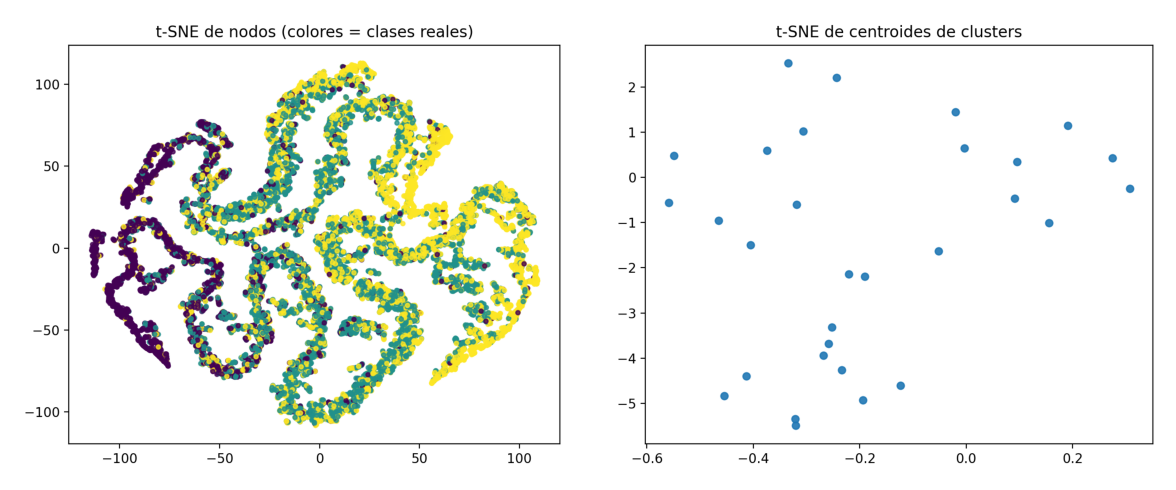

In [ ]:
img_nodes = plt.imread('tsne_nodes_diffpool.png')
img_clusters = plt.imread('tsne_clusters_diffpool.png')

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img_nodes)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_clusters)
plt.axis('off')

plt.tight_layout()
plt.show()

El modelo muestra una convergencia estable y una ligera mejora a lo largo del entrenamiento. Durante las primeras épocas, las métricas de clustering son bajas (NMI cercano a 0.01, ARI cercano a 0.007), lo que indica que las asignaciones iniciales de nodos a clusters aún no reflejan una estructura coherente. A partir de la época 100, el rendimiento comienza a estabilizarse, alcanzando valores máximos de NMI = 0.0506 y ARI = 0.0156, junto con un accuracy de 0.627. El número efectivo de clusters no vacíos también se estabiliza (alrededor de 30 de 128 posibles), indicando que el pooling concentra los nodos en un subconjunto de grupos representativos.

Por otro lado, mediante la interpretación visual, se observan agrupamientos visibles por color (clase real), aunque todavía con superposición entre regiones, lo que indica que las representaciones aprendidas por DiffPool separan parcialmente las clases. El t-SNE de los centroides muestra una distribución más dispersa pero con espacios regulares entre puntos.

En conjunto, los resultados indican que DiffPool logra una estructuración más coherente que aleatoria, reflejando cierta agrupación semántica en el embedding, aunque la coherencia global de los clusters sigue siendo limitada (NMI y ARI bajos). Visualmente, el modelo sí captura patrones de homogeneidad de clase, pero aún existe solapamiento entre clusters, probablemente debido a la complejidad del grafo y al número alto de clusters utilizados (K = 128).


## 3.3 MinCutPool (5 puntos)

En esta sección se entrenará un modelo Graphormer utilizando el método de pooling jerárquico MinCut. Para ello, siga los siguientes pasos:
1. Entrene un Graphormer con pooling jerárquico `MinCutPool` con 300 épocas.
2. Por cada 20 épocas, reporte los siguientes indicadores:
    - Pérdida de clasificación
    - Regularización
    - Accuracy del test
    - NMI y ARI
    - Promedio tamaño de clusters ± desviación estandar
3. Entrene t-SNE sobre los nodos en el *embedding* final y sobre los centroides, y grafique los resultados. Finalmente, comente sus resultados.

Respuesta:

In [ ]:
@dataclass
class Config:
    seed: int = 42
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 3
    pe_dim: int = 16
    num_clusters: int = 128
    dropout: float = 0.1
    lr: float = 1e-3
    weight_decay: float = 5e-4
    epochs: int = 300
    pooling: str = 'mincut'  # 'mincut' o 'diffpool'

set_seed(42)
cfg = Config()
device = torch.device(cfg.device)

data = data.to(device)

# Estructura densa para pooling
A_dense = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes).to(device)

# Embeddings Lap y Deg
pe = laplacian_pe(data.edge_index, data.num_nodes, cfg.pe_dim, device)  # (N, pe_dim)
deg_feat = degree_feature(data.edge_index, data.num_nodes, device)      # (N, 1)

In [ ]:
model = GraphormerLiteWithPooling(
        in_ch=dataset.num_features,
        num_classes=dataset.num_classes,
        d_model=cfg.d_model,
        n_heads=cfg.n_heads,
        n_layers=cfg.n_layers,
        pe_dim=cfg.pe_dim,
        num_clusters=cfg.num_clusters,
        dropout=cfg.dropout,
        pooling=cfg.pooling,
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

In [ ]:
history = []

for epoch in range(1, cfg.epochs + 1):
    model.train()
    opt.zero_grad()
    logits, Hn, S, reg = model(data, A_dense, pe, deg_feat)
    loss_ce = F.cross_entropy(logits[data.train_mask], data.y[data.train_mask])
    loss = loss_ce + 3e-2 * reg
    loss.backward()
    opt.step()

    if epoch % 20 == 0 or epoch == 1:
        mets = evaluate_metrics(model, data, A_dense, pe, deg_feat, cfg)
        reg_value = float(reg.detach())

        history.append({
            "epoch": epoch,
            "loss_cls": loss_ce.item(),
            "reg": reg_value,
            "total_loss": loss.item(),
            "acc_test": mets["acc_test"],
            "NMI": mets["nmi"],
            "ARI": mets["ari"],
            "cluster_mean": mets["cluster_mean"],
            "cluster_std": mets["cluster_std"],
            "K": mets["K"],
            "non_empty": mets["clusters_non_empty"],
            "pooling": cfg.pooling
        })

        print(
            f"[Epoch {epoch:03d}] "
            f"loss_cls={loss_ce.item():.4f}  reg={reg_value:.4f}  total={loss.item():.4f}  "
            f"acc_test={mets['acc_test']:.4f}  "
            f"NMI={mets['nmi']:.4f}  ARI={mets['ari']:.4f}  "
            f"cluster_size={mets['cluster_mean']:.1f}±{mets['cluster_std']:.1f} "
            f"(K={mets['K']}, non_empty={mets['clusters_non_empty']})"
        )

df_metrics = pd.DataFrame(history)

output_name = f"metrics_{cfg.pooling}.csv"
df_metrics.to_csv(output_name, index=False)

[Epoch 001] loss_cls=1528.2578  reg=-0.5417  total=1528.2416  acc_test=0.4070  NMI=0.0120  ARI=0.0075  cluster_size=1095.4±3776.3 (K=128, non_empty=18)
[Epoch 020] loss_cls=24.9662  reg=-0.5335  total=24.9502  acc_test=0.4070  NMI=0.0053  ARI=0.0028  cluster_size=4929.2±4427.6 (K=128, non_empty=4)
[Epoch 040] loss_cls=148.7778  reg=-0.5330  total=148.7618  acc_test=0.4070  NMI=0.0045  ARI=0.0028  cluster_size=6572.3±4809.9 (K=128, non_empty=3)
[Epoch 060] loss_cls=11.2118  reg=-0.5197  total=11.1962  acc_test=0.4360  NMI=0.0013  ARI=-0.0017  cluster_size=6572.3±7032.5 (K=128, non_empty=3)
[Epoch 080] loss_cls=18.6509  reg=-0.7965  total=18.6270  acc_test=0.4070  NMI=0.0110  ARI=-0.0012  cluster_size=2190.8±5957.0 (K=128, non_empty=9)
[Epoch 100] loss_cls=2.5408  reg=-0.7588  total=2.5181  acc_test=0.4560  NMI=0.1197  ARI=0.1121  cluster_size=2464.6±5306.4 (K=128, non_empty=8)
[Epoch 120] loss_cls=8.8148  reg=-0.8019  total=8.7907  acc_test=0.4800  NMI=0.0883  ARI=0.1035  cluster_size=1

In [ ]:
model.eval()
with torch.no_grad():
    logits, Hn, S, _ = model(data, A_dense, pe, deg_feat)
    clusters = S.argmax(dim=-1).detach().cpu().numpy() # (N,)
    X_nodes = Hn.detach().cpu().numpy()
    y = data.y.detach().cpu().numpy()

# t-SNE de nodos en el embedding final
tsne_nodes = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=cfg.seed)
Z2_nodes = tsne_nodes.fit_transform(X_nodes)

# t-SNE de centroides de clusters
# Centroides: media de Hn por cluster asignado duro
K = S.size(1)
centroids = []
for k in range(K):
    idx = np.where(clusters == k)[0]
    if len(idx) == 0:
        continue
    centroids.append(X_nodes[idx].mean(axis=0))
centroids = np.stack(centroids, axis=0)


tsne_clusters = TSNE(n_components=2, perplexity=min(30, max(5, len(centroids)//2)),
learning_rate='auto', init='pca', random_state=cfg.seed)
Z2_clusters = tsne_clusters.fit_transform(centroids)

plt.figure(figsize=(6,5))
plt.scatter(Z2_nodes[:,0], Z2_nodes[:,1], c=y, s=10, alpha=0.8)
plt.title('t-SNE de nodos (colores = clases reales)')
plt.tight_layout()
plt.savefig('tsne_nodes_mincut.png', dpi=200)
plt.close()

plt.figure(figsize=(6,5))
plt.scatter(Z2_clusters[:,0], Z2_clusters[:,1], s=30, alpha=0.9)
plt.title('t-SNE de centroides de clusters')
plt.tight_layout()
plt.savefig('tsne_clusters_mincut.png', dpi=200)
plt.close()

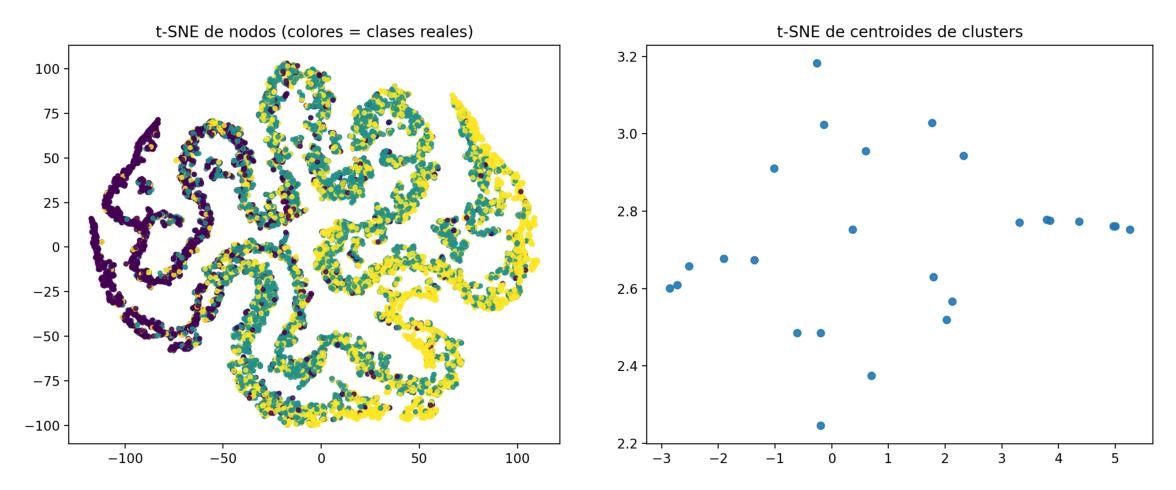

In [ ]:
img_nodes = plt.imread('tsne_nodes_mincut.png')
img_clusters = plt.imread('tsne_clusters_mincut.png')

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img_nodes)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_clusters)
plt.axis('off')

plt.tight_layout()
plt.show()

## 3.4 Conclusiones: DiffPool vs MinCutPool (5 puntos)

* ¿Qué modelo obtuvo mejor accuracy, NMI o ARI?

* ¿Qué diferencias se observaron en la convergencia de las pérdidas entre DiffPool y MinCutPool?

* ¿Hubo una diferencia clara en la capacidad de los modelos para formar clusters coherentes?

* ¿Cuál método mostró una mejor separación de clases en los gráficos t-SNE?

* ¿Cuál de los métodos recomendarías para este tipo de tarea y por qué?

Respuesta:

In [ ]:
metrics_diffpool = pd.read_csv('metrics_diffpool.csv')
metrics_mincut = pd.read_csv('metrics_mincut.csv')

In [ ]:
print("DiffPool")
print(f"Mejor accuracy: {metrics_diffpool['acc_test'].max():.4f}")
print(f"Mejor NMI: {metrics_diffpool['NMI'].max():.4f}")
print(f"Mejor ARI: {metrics_diffpool['ARI'].max():.4f}")
print(f"Promedio accuracy: {metrics_diffpool['acc_test'].mean():.4f}")
print(f"Promedio NMI: {metrics_diffpool['NMI'].mean():.4f}")
print(f"Promedio ARI: {metrics_diffpool['ARI'].mean():.4f}")

print("\nMinCut")
print(f"Mejor accuracy: {metrics_mincut['acc_test'].max():.4f}")
print(f"Mejor NMI: {metrics_mincut['NMI'].max():.4f}")
print(f"Mejor ARI: {metrics_mincut['ARI'].max():.4f}")
print(f"Promedio accuracy: {metrics_mincut['acc_test'].mean():.4f}")
print(f"Promedio NMI: {metrics_mincut['NMI'].mean():.4f}")
print(f"Promedio ARI: {metrics_mincut['ARI'].mean():.4f}")

DiffPool
Mejor accuracy: 0.6440
Mejor NMI: 0.0506
Mejor ARI: 0.0156
Promedio accuracy: 0.5294
Promedio NMI: 0.0330
Promedio ARI: 0.0036

MinCut
Mejor accuracy: 0.6160
Mejor NMI: 0.1197
Mejor ARI: 0.1121
Promedio accuracy: 0.5131
Promedio NMI: 0.0414
Promedio ARI: 0.0210


El modelo DiffPool alcanzó la mejor accuracy máxima (0.6440) y también un promedio de accuracy superior (0.5294 vs 0.5131), lo que indica un desempeño más estable en clasificación. Sin embargo, MinCut superó claramente a DiffPool en NMI y ARI, tanto en los valores máximos (NMI = 0.1197, ARI = 0.1121) como en los promedios (NMI = 0.0414, ARI = 0.0210), reflejando una mejor coherencia y calidad en la formación de clusters.

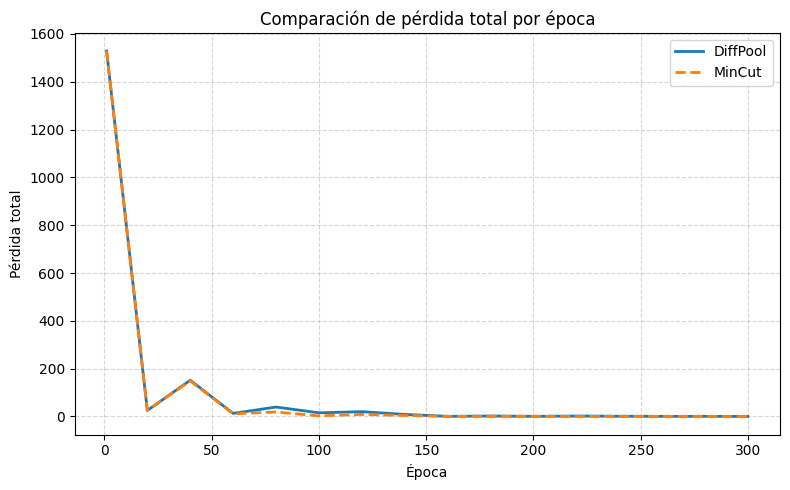

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(metrics_diffpool["epoch"], metrics_diffpool["total_loss"], label="DiffPool", linewidth=2)
plt.plot(metrics_mincut["epoch"], metrics_mincut["total_loss"], label="MinCut", linewidth=2, linestyle="--")

plt.title("Comparación de pérdida total por época")
plt.xlabel("Época")
plt.ylabel("Pérdida total")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

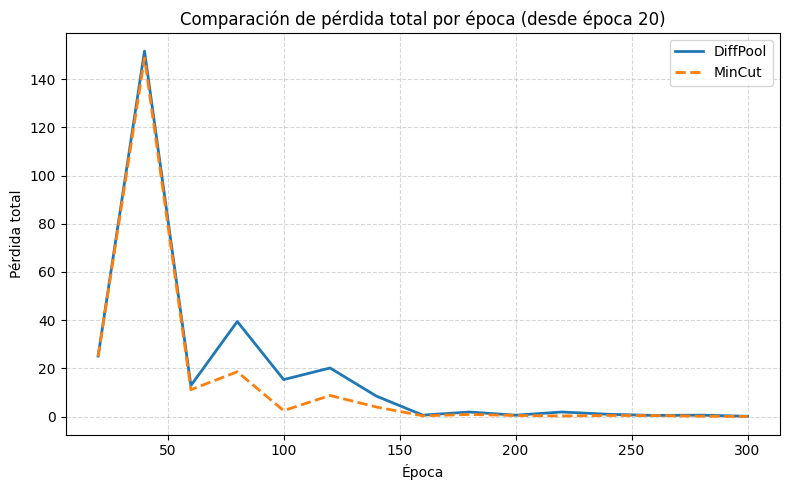

In [ ]:
metrics_diffpool = metrics_diffpool[metrics_diffpool["epoch"] >= 20]
metrics_mincut = metrics_mincut[metrics_mincut["epoch"] >= 20]

plt.figure(figsize=(8,5))
plt.plot(metrics_diffpool["epoch"], metrics_diffpool["total_loss"], label="DiffPool", linewidth=2)
plt.plot(metrics_mincut["epoch"], metrics_mincut["total_loss"], label="MinCut", linewidth=2, linestyle="--")

plt.title("Comparación de pérdida total por época (desde época 20)")
plt.xlabel("Época")
plt.ylabel("Pérdida total")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

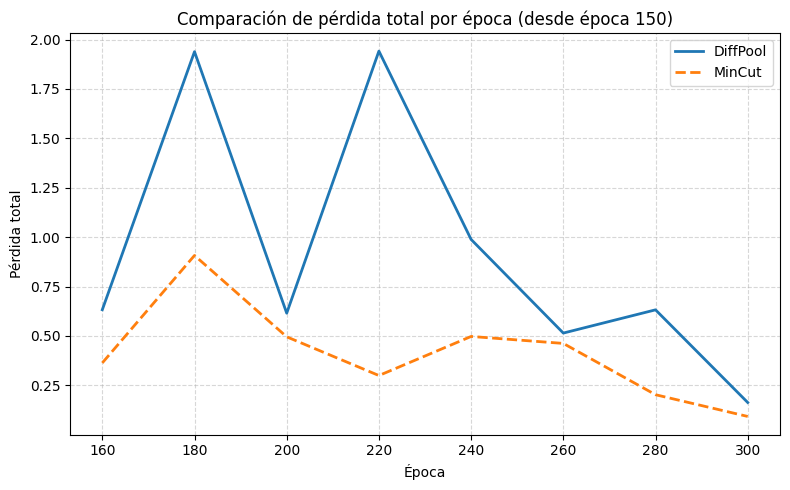

In [ ]:
metrics_diffpool = metrics_diffpool[metrics_diffpool["epoch"] >= 150]
metrics_mincut = metrics_mincut[metrics_mincut["epoch"] >= 150]

plt.figure(figsize=(8,5))
plt.plot(metrics_diffpool["epoch"], metrics_diffpool["total_loss"], label="DiffPool", linewidth=2)
plt.plot(metrics_mincut["epoch"], metrics_mincut["total_loss"], label="MinCut", linewidth=2, linestyle="--")

plt.title("Comparación de pérdida total por época (desde época 150)")
plt.xlabel("Época")
plt.ylabel("Pérdida total")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

MinCutPool mostró una convergencia más estable y suave que DiffPool.
Mientras que DiffPool tuvo oscilaciones en la pérdida incluso en etapas avanzadas, MinCutPool alcanzó valores menores y más consistentes desde la época 100 en adelante, indicando una mejor estabilidad durante el entrenamiento.

### ¿Hubo una diferencia clara en la capacidad de los modelos para formar clusters coherentes?

In [ ]:
metrics_diffpool = pd.read_csv('metrics_diffpool.csv')
metrics_mincut = pd.read_csv('metrics_mincut.csv')

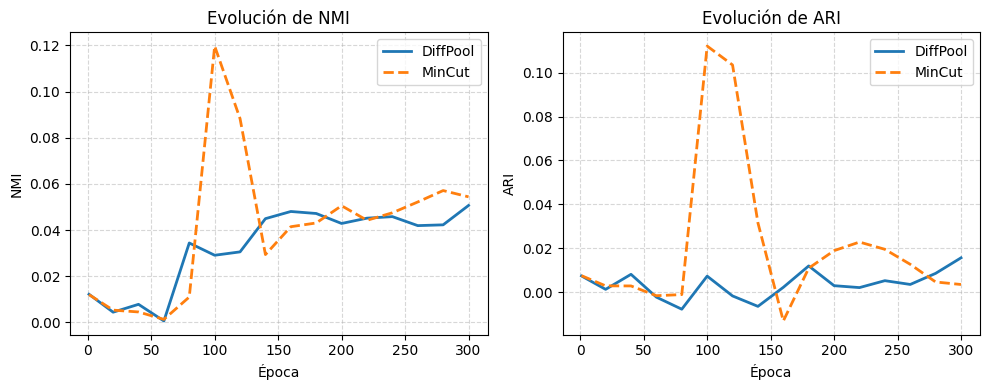

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(metrics_diffpool["epoch"], metrics_diffpool["NMI"], label="DiffPool", linewidth=2)
plt.plot(metrics_mincut["epoch"], metrics_mincut["NMI"], label="MinCut", linewidth=2, linestyle="--")
plt.title("Evolución de NMI")
plt.xlabel("Época"); plt.ylabel("NMI"); plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)

plt.subplot(1,2,2)
plt.plot(metrics_diffpool["epoch"], metrics_diffpool["ARI"], label="DiffPool", linewidth=2)
plt.plot(metrics_mincut["epoch"], metrics_mincut["ARI"], label="MinCut", linewidth=2, linestyle="--")
plt.title("Evolución de ARI")
plt.xlabel("Época"); plt.ylabel("ARI"); plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Según los gráficos, MinCut presenta picos más altos en NMI y ARI, especialmente alrededor de la época 100, lo que indica que forma clusters más coherentes y mejor alineados con las etiquetas reales. En cambio, DiffPool muestra una evolución más estable pero con valores más bajos, reflejando clusters menos definidos pero más consistentes a lo largo del entrenamiento.

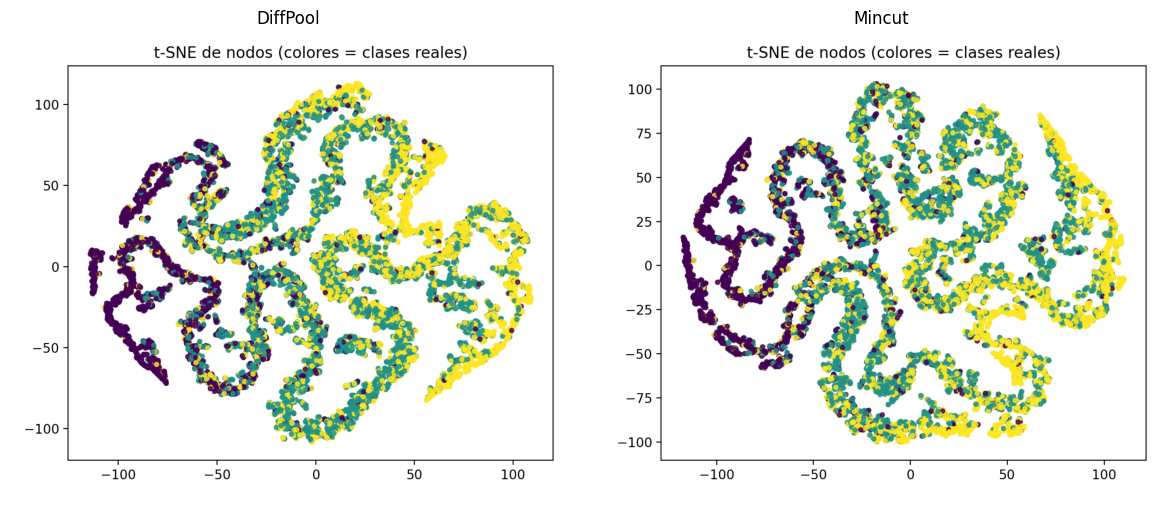

In [ ]:
img_nodes_diffpool = plt.imread('tsne_nodes_diffpool.png')
img_nodes_mincut = plt.imread('tsne_nodes_mincut.png')

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img_nodes_diffpool)
plt.title("DiffPool")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_nodes_mincut)
plt.title("Mincut")
plt.axis('off')

plt.tight_layout()
plt.show()

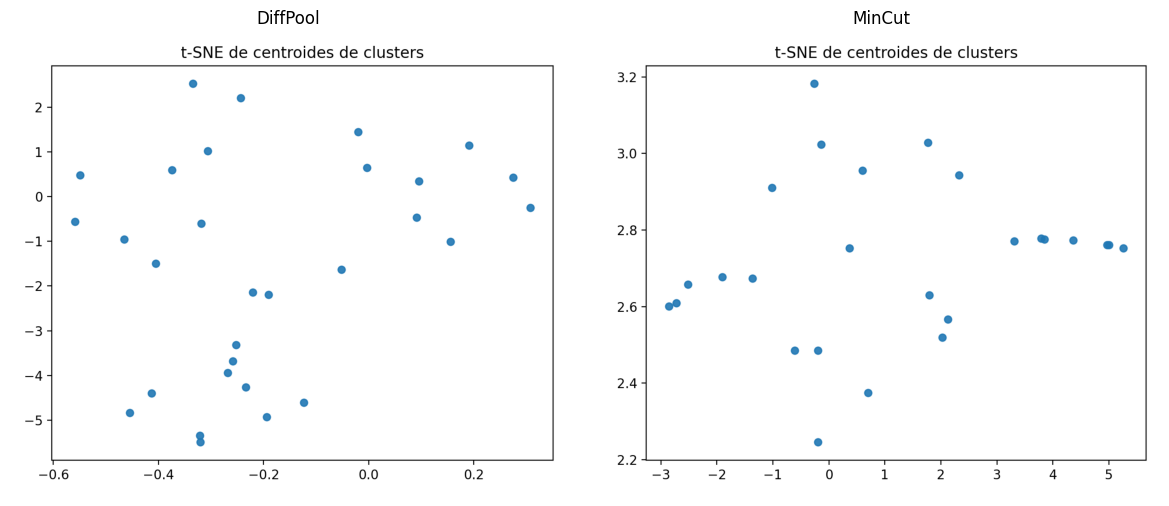

In [ ]:
img_clusters_diffpool = plt.imread('tsne_clusters_diffpool.png')
img_clusters_mincut = plt.imread('tsne_clusters_mincut.png')

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img_clusters_diffpool)
plt.title("DiffPool")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_clusters_mincut)
plt.title("MinCut")
plt.axis('off')

plt.tight_layout()
plt.show()

MinCut mostró una mejor separación entre clases, con regiones más distinguibles y menor superposición entre colores. Por el contrario, DiffPool presenta una mezcla más difusa entre clases, indicando que sus embeddings son menos discriminativos visualmente. Además, los t-SNE de los centroides refuerzan esta conclusión, los centroides de MinCut se distribuyen de manera más organizada y diferenciada, mientras que en DiffPool aparecen más dispersos y sin una estructura clara, lo que sugiere una menor coherencia en los agrupamientos.

### ¿Cuál de los métodos recomendarías para este tipo de tarea y por qué?

Recomendaría MinCutPool, debido a que mostró mejor capacidad para formar clusters coherentes (NMI = 0.12, ARI = 0.11) y una estructura más organizada tanto en los embeddings de nodos como en los centroides, lo que indica que logra capturar mejor las relaciones semánticas entre artículos. Dado que PubMed es un grafo grande, donde las conexiones entre nodos reflejan similitud temática, MinCutPool resulta más adecuado porque preserva la estructura global del grafo y produce agrupaciones más interpretables, mientras que DiffPool tiende a generar asignaciones más difusas y menos informativas.